# Exercise 10.1

An “effect size” is a statistic intended to measure the difference between two groups (see http://en.wikipedia.org/wiki/Effect_size).
For example, we could use data from the BRFSS to estimate the difference in height between men and women. By sampling values from the posterior distributions of μ and σ, we could generate the posterior distribution of this difference.
But it might be better to use a dimensionless measure of effect size, rather than a difference measured in cm. One option is to use divide through by the standard deviation (similar to what we did with the coefficient of variation).
If the parameters for Group 1 are $(\mu_1,\sigma_1)$, and the parameters for Group 2 are $(\mu_2,\sigma_2)$, the dimensionless effect size is
$$\frac{\mu_1-\mu_2}{(\sigma_1+\sigma_2)/2}$$

Write a function that takes joint distributions of mu and sigma for two groups and returns the posterior distribution of effect size.

Hint: if enumerating all pairs from the two distributions takes too long, consider random sampling. 

### Theory

Let's first summarize the problem with a little bit of math. At this point we are getting familiar with what needs to be done. But since I'm a slow learner I might as well write it too many than too few times.

For each group, male and female, we are looking at the mean and standard deviation, $(\mu_1,\sigma_1)$ and $(\mu_2,\sigma_2)$ respectively.

$P(\mu, \sigma|Data)=\frac{P(Data|\mu, \sigma)P(\mu, \sigma)}{P(Data)}$

where

$P(Data|\mu, \sigma) \sim \mathcal N(\mu, \sigma)$ and $Data$ is the height of a person. Calculating the posterior $P(\mu, \sigma|Data)$ for the first person will become the prior for the next one which will in turn become the prior of the next one and so on and so on. It would normally not be a problem because we would normalize by $P(Data)$ for every person. But doing so will take a long time and there are optimizations. 

#### Underflow

Another way of looking at the problem is by calculating (mind the $\propto$)

$P(\mu, \sigma|h_1, h_2,\dots, h_n)=\
\frac{P(\mu, \sigma,h_1, h_2,\dots, h_n)}{P(h_1, h_2,\dots, h_n)}\propto\
P(\mu, \sigma)P(h_1|\mu, \sigma)\prod_{i=0}^{i=n-2}{P(h_{n-i}|\mu, \sigma,h_1,\dots, h_{n-i-1})}$

We will end up multiplying a whole bunch of gaussians. As mathematicians we don't care, but as computer scientist we have to worry about underflow. The oldest trick in the book is to sum the logs instead.

$log\left(P(\mu, \sigma|h_1, h_2,\dots, h_n)\right)\propto\
log(P(\mu, \sigma))+log(P(h_1|\mu, \sigma))+\sum_{i=0}^{i=n-2}log({P(h_{n-i}|\mu, \sigma,h_1,\dots, h_{n-i-1})})$

$P(Data)$ is the sum of all the $\mu$ and $\sigma$ that we want to try. The Suite object provided does all that calculation for us. Writing down that part of the math is cumbersome, but goes like this

$\sum_{\mu \in M , \sigma \in \Sigma}\left\{{P(\mu, \sigma)P(h_1|\mu, \sigma)\prod_{i=0}^{i=n-2}{P(h_{n-i}|\mu, \sigma,h_1,\dots, h_{n-i-1})}}\right\}$

The author goes to another round of optimisation, but I will stop here because I only wanted to lay down the bayesian math behind the *Underflow* reasoning.

### Practice

Here I use the code from the author straight away. No need to reimplement everything ourselves, especially not the optimisations.

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'code'))

In [43]:
from variability import UpdateSuite3, FindPriorRanges, Height
import brfss
from thinkbayes2 import Pmf, MakeCdfFromPmf
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def ReadHeights(nrows=None):
    """Read the BRFSS dataset, extract the heights and pickle them.

    nrows: number of rows to read
    
    This is exactly the same function as provided in 'variability', I just copied it so I can change the import path.
    It was the easy way instead of refactoring everything to expose that parameter.
    """
    resp = brfss.ReadBrfss(filename="code/CDBRFS08.ASC.gz", nrows=nrows).dropna(subset=['sex', 'htm3'])
    groups = resp.groupby('sex')

    d = {}
    for name, group in groups:
        d[name] = group.htm3.values

    return d

In [6]:
d = ReadHeights(nrows=None)
labels = {1:'male', 2:'female'}

# PlotCdfs(d, labels)

suites = {}
for key, xs in d.items():
    label = labels[key]

    mus, sigmas = FindPriorRanges(xs, 31)
    suite = Height(mus, sigmas, label)
    suites[label] = suite
    UpdateSuite3(suite, xs)
    print('MLE', suite.MaximumLikelihood())

#     PlotPosterior(suite)

    pmf_m = suite.Marginal(0)
    pmf_s = suite.Marginal(1)
    print('marginal mu', pmf_m.Mean(), pmf_m.Var())
    print('marginal sigma', pmf_s.Mean(), pmf_s.Var())

    # PlotMarginals(suite)

# PlotCoefVariation(suites)

classical estimators 178.066221091 7.72353844434
MLE (178.06622109101272, 7.7235384443386268)
marginal mu 178.066221091 0.000378590170384
marginal sigma 7.72361968883 0.00018929458259
classical estimators 163.223475004 7.26914201782
MLE (163.22347500412215, 7.2691420178248141)
marginal mu 163.223475005 0.000203282582622
marginal sigma 7.26918836916 0.000101641131228


In [29]:
def EffectSize(suite1, suite2):
    """Computes the distribution of effect size.

    suite 1 and 2: Pmf that maps (mu, s) to a probability

    Returns: Normalized Pmf object containing the probability of the effect size from both suites.
    """
    pmf = Pmf()
    for (m1, s1), p1 in suite1.Items():
        for (m2, s2), p2 in suite2.Items():
            effect_size = (m1-m2)/((s1+s2)/2)
            pmf.Incr(effect_size, p1*p2)
    pmf.Normalize()
    return pmf
        

In [30]:
pmf = EffectSize(suites['male'], suites['female'])

In [31]:
xs, probs = zip(*sorted(pmf.Items()))

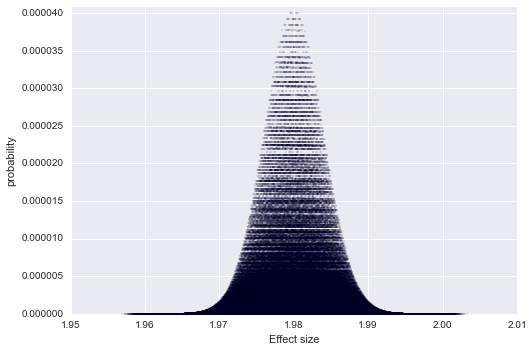

In [42]:
plt.scatter(xs, probs, s=0.1)
plt.ylim(0, max(probs))
plt.xlabel('Effect size')
_ = plt.ylabel('probability')

Looking at that plot above shows that there are holes in our evaluation. We can only estimate so many value of $\mu$ and $\sigma$. If we could evaluate enough of them, we would only have points on the curve and not inside. So let's look at the CDF instead.

In [46]:
cdf = MakeCdfFromPmf(pmf)

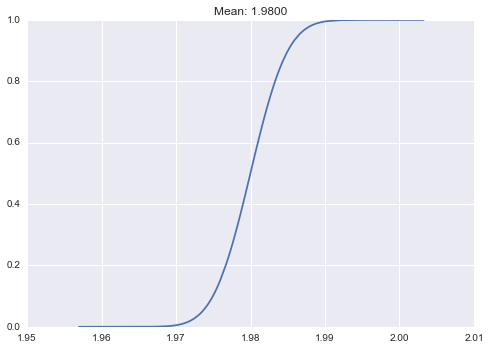

In [56]:
plt.plot(cdf.xs, cdf.ps)
_ = plt.title("Mean: {:.4f}".format(cdf.Mean()))

Typical shape of a bell curve.